In [9]:
import sys
from pathlib import Path

# Adiciona o caminho da pasta src ao sys.path
sys.path.append(str(Path("../src").resolve()))

In [10]:
from evaluation import *
from classifiers import BayesianKNNClassifier, BayesianLogisticRegression, MajorityVoteClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np
import pandas as pd
import joblib
from collections import Counter

In [11]:
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# Carrega os dados balanceados e normalizados
X_train, y_train = joblib.load("../data/train_balanced.pkl")
X_val, y_val = joblib.load("../data/val_balanced.pkl")
X_test, y_test = joblib.load("../data/test_balanced.pkl")

# Junta tudo para clustering (sem separar)
X = np.concatenate([X_train, X_val, X_test], axis=0)
y = np.concatenate([y_train, y_val, y_test], axis=0)

print("Shape dos dados:", X.shape)
print("Distribuição das classes:", Counter(y))

Shape dos dados: (424, 44)
Distribuição das classes: Counter({np.int64(0): 212, np.int64(1): 212})


In [13]:
N_RUNS = 30
N_FOLDS = 10
SEED = 42
rng = np.random.RandomState(SEED)

results_knn = []
results_logistic = []
results_majority = []

In [14]:
best_knn_params = select_best_bayesian_knn(X, y)
best_logistic_params = select_best_logistic(X, y)

C:\Users\Laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: Conve

In [15]:
# Modelos
knn_model = BayesianKNNClassifier(**best_knn_params)
logistic_model = BayesianLogisticRegression(**best_logistic_params)
majority_model = MajorityVoteClassifier([knn_model, logistic_model])

In [16]:
# Avaliação com validação cruzada 30x10
df_knn = cross_validate_model(knn_model, X, y, n_runs=N_RUNS, n_folds=N_FOLDS, seed=SEED)
df_logistic = cross_validate_model(logistic_model, X, y, n_runs=N_RUNS, n_folds=N_FOLDS, seed=SEED)
df_majority = cross_validate_model(majority_model, X, y, n_runs=N_RUNS, n_folds=N_FOLDS, seed=SEED)

C:\Users\Laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Laura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_sag.py:348: Conve

In [17]:
print("Resultados - KNN Bayesiano")
print("Média:", df_knn["accuracy"].mean())
print("Desvio padrão:", df_knn["accuracy"].std())

print("\nResultados - Regressão Logística")
print("Média:", df_logistic["accuracy"].mean())
print("Desvio padrão:", df_logistic["accuracy"].std())

print("\nResultados - Votação Majoritária")
print("Média:", df_majority["accuracy"].mean())
print("Desvio padrão:", df_majority["accuracy"].std())

Resultados - KNN Bayesiano
Média: 0.8101273532668881
Desvio padrão: 0.051557261344774105

Resultados - Regressão Logística
Média: 0.8279512735326687
Desvio padrão: 0.054487016848240276

Resultados - Votação Majoritária
Média: 0.7846659283868586
Desvio padrão: 0.05299260755944637


In [18]:
from evaluation import friedman_test, prepare_friedman_input

metric = "f1"
metric_data = prepare_friedman_input([df_knn, df_logistic, df_majority], metric=metric)
stat, p = friedman_test(*metric_data)

print(f"Friedman test ({metric}): χ² = {stat:.4f}, p = {p:.4f}")

Friedman test (f1): χ² = 298.5270, p = 0.0000


In [19]:
import numpy as np
from scipy.stats import t

def summarize_metrics(df, label):
    metrics = ["accuracy", "precision", "recall", "f1"]
    print(f"\nResultados para {label}:")
    for metric in metrics:
        values = df[metric].dropna().values  
        if len(values) == 0:
            print(f"- {metric.capitalize()}: sem dados.")
            continue

        mean = np.mean(values)
        std = np.std(values, ddof=1)
        n = len(values)
        ci = t.ppf(0.975, n-1) * std / np.sqrt(n)

        if metric == "accuracy":
            print(f"- Erro: {1 - mean:.4f} ± {ci:.4f}")
        print(f"- {metric.capitalize()}: {mean:.4f} ± {ci:.4f}")



summarize_metrics(df_knn, "Bayesian kNN")
summarize_metrics(df_logistic, "Regressão Logística")
summarize_metrics(df_majority, "Majority Voting")


Resultados para Bayesian kNN:
- Erro: 0.1899 ± 0.0059
- Accuracy: 0.8101 ± 0.0059
- Precision: 0.9833 ± 0.0039
- Recall: 0.6316 ± 0.0115
- F1: 0.7643 ± 0.0088

Resultados para Regressão Logística:
- Erro: 0.1720 ± 0.0062
- Accuracy: 0.8280 ± 0.0062
- Precision: 0.8685 ± 0.0078
- Recall: 0.7783 ± 0.0099
- F1: 0.8174 ± 0.0071

Resultados para Majority Voting:
- Erro: 0.2153 ± 0.0060
- Accuracy: 0.7847 ± 0.0060
- Precision: 0.9913 ± 0.0031
- Recall: 0.5749 ± 0.0120
- F1: 0.7218 ± 0.0098


In [20]:
def print_conf_intervals(name, df):
    print(f"\nIntervalo de confiança para {name}:")
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        mean, h = intervalo_confianca(df[metric])
        print(f"{metric.capitalize()}: {mean:.4f} ± {h:.4f} (95% CI)")

print_conf_intervals("Bayesian k-NN", df_knn)
print_conf_intervals("Regressão Logística", df_logistic)
print_conf_intervals("Majority Voting", df_majority)


Intervalo de confiança para Bayesian k-NN:
Accuracy: 0.8101 ± 0.0059 (95% CI)
Precision: 0.9833 ± 0.0039 (95% CI)
Recall: 0.6316 ± 0.0115 (95% CI)
F1: 0.7643 ± 0.0088 (95% CI)

Intervalo de confiança para Regressão Logística:
Accuracy: 0.8280 ± 0.0062 (95% CI)
Precision: 0.8685 ± 0.0078 (95% CI)
Recall: 0.7783 ± 0.0099 (95% CI)
F1: 0.8174 ± 0.0071 (95% CI)

Intervalo de confiança para Majority Voting:
Accuracy: 0.7847 ± 0.0060 (95% CI)
Precision: 0.9913 ± 0.0031 (95% CI)
Recall: 0.5749 ± 0.0120 (95% CI)
F1: 0.7218 ± 0.0098 (95% CI)



[FRIEDMAN] accuracy: stat=182.6255, p=0.0000
[NEMENYI] accuracy:
           0         1    2
0  1.000000  0.036031  0.0
1  0.036031  1.000000  0.0
2  0.000000  0.000000  1.0


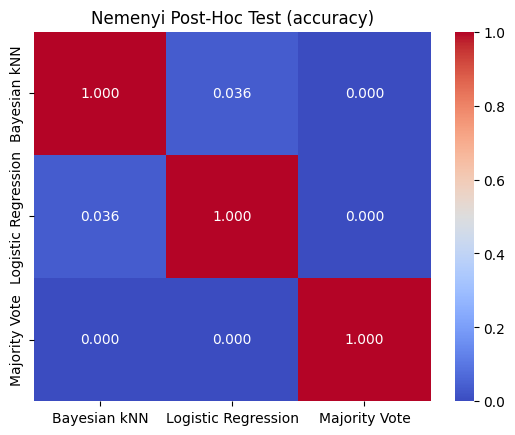


[FRIEDMAN] precision: stat=469.2653, p=0.0000
[NEMENYI] precision:
           0    1         2
0  1.000000  0.0  0.512645
1  0.000000  1.0  0.000000
2  0.512645  0.0  1.000000


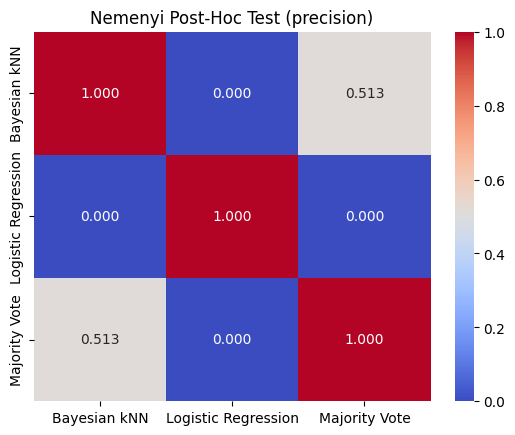


[FRIEDMAN] recall: stat=515.5586, p=0.0000
[NEMENYI] recall:
      0    1    2
0  1.0  0.0  0.0
1  0.0  1.0  0.0
2  0.0  0.0  1.0


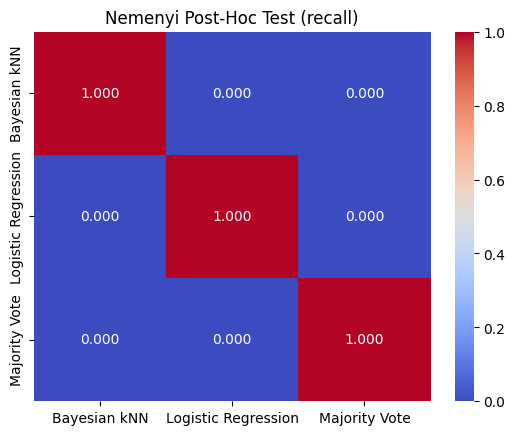


[FRIEDMAN] f1: stat=298.5270, p=0.0000
[NEMENYI] f1:
               0             1    2
0  1.000000e+00  1.261394e-09  0.0
1  1.261394e-09  1.000000e+00  0.0
2  0.000000e+00  0.000000e+00  1.0


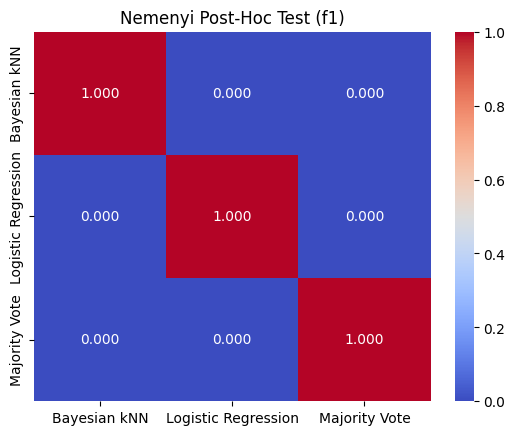

In [22]:
for metric in ["accuracy", "precision", "recall", "f1"]:
    df_metrics = pd.DataFrame({
        "Bayesian kNN": df_knn[metric].values,
        "Logistic Regression": df_logistic[metric].values,
        "Majority Vote": df_majority[metric].values
    })

    # Friedman
    friedman_stat, p_val = friedman_test(
        df_metrics["Bayesian kNN"].values,
        df_metrics["Logistic Regression"].values,
        df_metrics["Majority Vote"].values
    )
    print(f"\n[FRIEDMAN] {metric}: stat={friedman_stat:.4f}, p={p_val:.4f}")

    # Nemenyi
    nemenyi_results = sp.posthoc_nemenyi_friedman(df_metrics.values)
    print(f"[NEMENYI] {metric}:\n", nemenyi_results)

    # Heatmap
    sns.heatmap(nemenyi_results, annot=True, fmt=".3f", cmap="coolwarm",
                xticklabels=df_metrics.columns,
                yticklabels=df_metrics.columns)
    plt.title(f"Nemenyi Post-Hoc Test ({metric})")
    plt.show()
